In [17]:
import numpy as np
import scipy as sci

In [23]:
from scipy.special import logsumexp

In [149]:
import numpy.matlib

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] =[12,9]

In [4]:
transp = np.array([[0.99, 0.01], [0.02, 0.98]])
emissp = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6], [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]])

In [5]:
pi = np.array([0.5, 0.5])

In [6]:
def simulate(N):
    hs = []
    xs = []
    ht = np.random.choice([0,1], p=pi)
    hs.append(ht)
    for _ in range(N-1):
        ht = np.random.choice([0, 1],p=transp[ht, :])
        hs.append(ht)
    for h in hs:
        xt = np.random.choice(range(6), p=emissp[h, :])
        xs.append(xt)
    return hs, xs

In [7]:
def HMMViterbi(v):
    N = len(v)
    trace = np.zeros((N, 2))
    trace[0, 0] = np.log(pi[0]) + np.log(emissp[0, v[0]])
    trace[0, 1] = np.log(pi[1]) + np.log(emissp[1, v[0]])
    traj = np.ones((N, 2)) * -1
    for i in range(1, N):
        s00 = np.log(transp[0, 0]) + np.log(emissp[0, v[i]]) + trace[i-1, 0]
        s10 = np.log(transp[1, 0]) + np.log(emissp[0, v[i]]) + trace[i-1, 1]
        if s00 > s10:
            trace[i, 0] = s00
            traj[i, 0] = 0
        else:
            trace[i, 0] = s10
            traj[i, 0] = 1
        s01 = np.log(transp[0, 1]) + np.log(emissp[1, v[i]]) + trace[i-1, 0]
        s11 = np.log(transp[1, 1]) + np.log(emissp[1, v[i]]) + trace[i-1, 1]
        if s01 > s11:
            trace[i, 1] = s01
            traj[i, 1] = 0
        else:
            trace[i, 1] = s11
            traj[i, 1] = 1
    hs = []
    last = -1
    if trace[N-1, 0] > trace[N-1, 1]:
        last = 0
    else:
        last = 1
    hs.append(last)
    for i in range(N-1, 0, -1):
        #print("i = {}, last = {}".format(i, last))
        last = int(traj[i, last])
        hs.append(last)
    return list(reversed(hs))

In [11]:
def HMMViterbi(v):
    N = len(v)
    trace = np.zeros((N, 2))
    trace[0, :] = np.log(pi) + np.log(emissp[:, v[0]])
    traj = np.ones((N, 2)) * -1
    for i in range(1, N):
        #s0 = np.log(transp[:, 0]) + np.log(emissp[0, v[i]]) + trace[i-1, :]
        #trace[i, 0] = np.max(s0)
        #traj[i, 0] = np.argmax(s0)
        #s1 = np.log(transp[:, 1]) + np.log(emissp[1, v[i]]) + trace[i-1, :]
        #trace[i, 1] = np.max(s1)
        #traj[i, 1] = np.argmax(s1)
        s = np.log(transp.T) + np.log(emissp[:, v[i]]) + trace[i-1,:]
        trace[i,:] = np.max(s.T, axis=0)
        traj[i, :] = np.argmax(s.T, axis=0)
    hs = []
    last = np.argmax(trace[N-1,:])
    hs.append(last)
    for i in range(N-1, 0, -1):
        last = int(traj[i, last])
        hs.append(last)
    return list(reversed(hs))

<Container object of 800 artists>

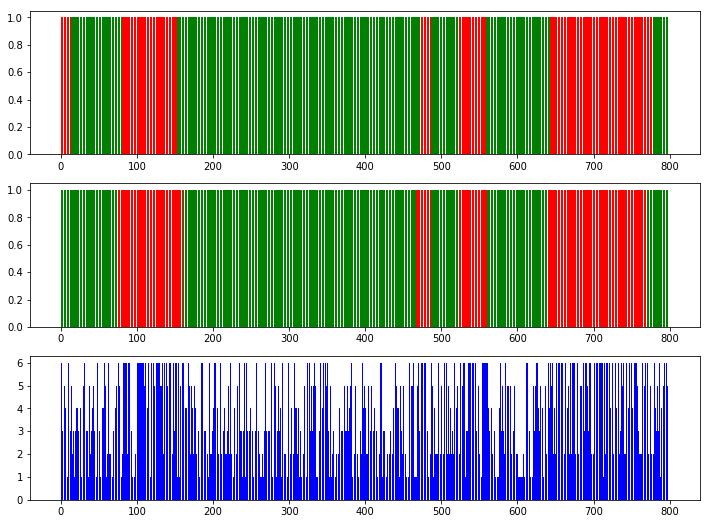

In [14]:
def viterbiPlot():
    hs, vs = simulate(800)
    phs = HMMViterbi(vs)

    #vs, hs, phs

    hscolor = ['green' if h == 0 else 'red' for h in hs]

    phscolor = ['green' if h == 0 else 'red' for h in phs]

    fig, ax = plt.subplots(3, 1)
    ax[0].bar(range(len(hs)), 1, color=hscolor)
    ax[1].bar(range(len(hs)), 1, color=phscolor)
    ax[2].bar(range(len(hs)), np.array(vs)+1,color='blue')

In [74]:
def divide(n, d):
    r = np.zeros(n.shape)
    for i in range(len(n)):
        r[i, :] = n[i, :] / d[i]
    return r

In [77]:
def condp(pin):
    if len(pin.shape) == 1:
        return np.divide(pin, np.sum(pin))
    p = np.sum(pin, axis=1)
    return divide(pin, p)

In [118]:
def condexp(logp):
    if len(logp.shape) == 1:
        maxlogp = np.max(logp)
        logp -= maxlogp
    else:
        maxlogp = np.max(logp, axis=1)
        logp = (logp.T - maxlogp).T
    return condp(np.exp(logp))

In [119]:
condexp(np.log(np.array([[1,2],[3,4],[5,6],[1,10]])))

array([[ 0.33333333,  0.66666667],
       [ 0.42857143,  0.57142857],
       [ 0.45454545,  0.54545455],
       [ 0.09090909,  0.90909091]])

In [120]:
condexp(np.log(np.array([1,2])))

array([ 0.33333333,  0.66666667])

In [80]:
def HMMforward(v, N, K, pi_, emissp_, transp_):
    logalpha = np.ones((N, K)) * -np.inf
    logalpha[0, :] = np.log(pi_) + np.log(emissp_[:, v[0]])
    for i in range(1, N):
        logalpha[i, :] = np.log(emissp_[:, v[i]]) + logsumexp(logalpha[i-1, :] + np.log(transp_.T), axis=1)
    return logalpha, logsumexp(logalpha[N-1,:])

In [81]:
def HMMbackward(v, N, K, emissp_, transp_):
    logbeta = np.ones((N, K)) * -np.inf
    logbeta[N-1, :] = np.zeros(K)
    for i in range(N-2, -1, -1):
        logbeta[i, :] = logsumexp(logbeta[i+1, :] + np.log(emissp_[:, v[i+1]]) + np.log(transp_), axis=1)
    return logbeta

In [162]:
def HMMsmooth(logalpha, logbeta, v, N, K, emissp_, transp_):
    r = np.zeros((N, K))
    for i in range(N):
        r[i, :] = logalpha[i, :] + logbeta[i, :]
    r = condexp(r)
    A = np.zeros((K, K, N))
    for i in range(1, N):
        #for k1 in range(K):
            #for k2 in range(K):
            #    A[k1, k2, i] = logalpha[i-1, k1] + logbeta[i, k2] + np.log(emissp_[k2, v[i]]) + np.log(transp_[k1, k2])
        #    A[k1, :, i] = logalpha[i-1, k1] + logbeta[i, :] + np.log(emissp_[:, v[i]]) + np.log(transp_[k1, :])
        A[:, :, i] = np.matlib.repmat(logalpha[i-1, :].reshape(-1,1), 1, 2) + logbeta[i, :] + np.log(emissp_[:, v[i]]) + np.log(transp_[:, :])
        logmax = np.max(A[:, :, i])
        A[:, :, i] -= logmax
        A[:, :, i] = np.exp(A[:, :, i])
        A[:, :, i] = A[:, :, i] / np.sum(A[:, :, i])
    return r, A

In [163]:
def HMMem(V, N, K, D, niters):
    ph1 = condp(np.random.rand(K)) # pi
    #ph1 = pi
    phthtp = condp(np.random.rand(K, K)) # transp
    #phthtp = condp(np.array([[0.6, 0.4],[0.4, 0.6]])) # transp
    #phthtp = transp
    pvtht = condp(np.random.rand(K, D)) # emissp
    #pvtht = emissp
    times = 0
    lastllik = -np.inf
    for i in range(niters):
        a = np.zeros(K)
        A = np.zeros((K, K))
        B = np.zeros((K, D))
        llik = 0
        for m in range(len(V)):
            v = V[m]
            # E-step
            logalpha, llik_ = HMMforward(v, N, K, ph1, pvtht, phthtp)
            logbeta = HMMbackward(v, N, K, pvtht, phthtp)
            #print("logalpha: {}".format(logalpha))
            #print("logbeta: {}".format(logbeta))
            r, A_ = HMMsmooth(logalpha, logbeta, v, N, K, pvtht, phthtp)
            llik += llik_
            #print("r: {}".format(r))
            #print("A_: {}".format(A_))
            # collect
            a += r[0, :]
            A += np.sum(A_, axis=2)
            #print("A : {}".format(A))
            for j in range(N):
                B[:, v[j]] += r[j, :]
        # M-step
        ph1 = condp(a)
        phthtp = condp(A)
        pvtht = condp(B)
        llik /= len(V)
        #print("ph1: {}".format(ph1))
        #print("phthtp: {}".format(phthtp))
        #print("pvtht: {}".format(pvtht))
        print("---- log likelihood: {}".format(llik))
        if llik - lastllik < 0.003:
            times += 1
        else:
            times = 0
        if times >= 5:
            break
        lastllik = llik
    return ph1, phthtp, pvtht, llik


In [147]:
def observes():
    M = 100
    N = 800
    vs = np.zeros((M, N), dtype=int)
    for m in range(M):
        _, v = simulate(N)
        vs[m, :] = np.array(v, dtype=int)

In [146]:
#HMMem(vs, len(vs), 2, 6, 100)

In [154]:
np.matlib.repmat(np.array([[1],[2]]), 1,2)

array([[1, 1],
       [2, 2]])

In [155]:
a = np.array([1,2])
b = np.array([10, 20])

In [156]:
a + b

array([11, 22])

In [160]:
np.matlib.repmat(a.reshape(-1, 1), 1, 2)

array([[1, 1],
       [2, 2]])

In [157]:
c = np.matlib.repmat(a.reshape(-1,1), 1, 2) + b
c

array([[11, 21],
       [12, 22]])

In [158]:
c[0,:]

array([11, 21])